In [1]:
#import modules
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os
import math
from PIL import Image


# For reading and conversion to gray.

In [2]:
def show_image(img_name, img, cmap):
    ans = int(input('\nSave(0) or Show(1) image? '))
    if ans==0:
        save_dir = './images'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.imsave(save_dir+'/'+img_name, img, cmap=cmap)
        print('\nImage saved! Check images folder.')
    else:
        plt.axis("off")
        plt.imshow(img, cmap=cmap)
        plt.show()

In [3]:
# For reading and conversion to gray
img = cv2.imread('./images/Butterfly.JPG')

def convert_to_grayscale(image):
    B = image[:,:,0]
    G = image[:,:,1]
    R = image[:,:,2]
    img_gray = 0.2989*R + 0.5870*G + 0.1140*B
    img_gray = img_gray.astype('uint8')
    return img_gray

### Adding Gaussian Noise

In [ ]:
# adding gaussian noise
img = cv2.imread('./images/Butterfly.JPG')
def gaussian_noise(img):
    mean = 0
    var = 10
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, (4000, 6000)) #  np.zeros((224, 224), np.float32)

    noisy_image = np.zeros(img.shape, np.float32)

    if len(img.shape) == 2:
        noisy_image = img + gaussian
    else:
        noisy_image[:, :, 0] = img[:, :, 0] + gaussian
        noisy_image[:, :, 1] = img[:, :, 1] + gaussian
        noisy_image[:, :, 2] = img[:, :, 2] + gaussian

    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy_image = noisy_image.astype(np.uint8)

    cv2.imwrite("./images/img.jpg", img)
    cv2.imwrite("./images/gaussian.jpg", gaussian)
    cv2.imwrite("./images/noisy.jpg", noisy_image)
    
gaussian_noise(img)

### Adding Gaussian Filter

In [4]:
def isvalid(i, j, r, c):
    if i >= r or j >= c or i < 0 or j < 0:
        return 0
    return 1
def gaussian(m, n, sigma = 1):
    g = np.zeros((m,n))
    m = m // 2
    n = n // 2
    for i in range(-m,m+1):
        for j in range(-n,n+1):
            den = 2.0*np.pi*(sigma**2)
            num = np.exp(-(i**2 + j**2) / (2*(sigma**2)))
            g[i+m][j+n] = num / den
    return g
def filter2D(image, kernel):
    r, c = image.shape
    m, n = kernel.shape
    filtered = np.zeros(image.shape)
    dx, dy = m//2, n//2
    for i in range(r):
        for j in range(c):
            psum = 0.0
            for k in range(i-dx,i+dx+1):
                for l in range(j-dy,j+dy+1):
                    if isvalid(k,l,r,c):
                        psum += image[k][l] * kernel[i-k+dx][j-l+dy]
            filtered[i][j] = psum
    return filtered

def scaling(image, sigmag = 3, k = 5):
    kernel = gaussian(k,k,sigmag)
    scaled = filter2D(image,kernel)
    return scaled

In [5]:
def sharpen(image):
    laplacian = np.array(
    [
        [-1,-1,-1],
        [-1,8,-1],
        [-1,-1,-1]
    ])
    lap = filter2D(image, laplacian)
    lap = lap - np.min(lap)
    lap = lap * (255.0 / np.max(lap))
    
    sharpened = image + lap
    sharpened = sharpened - np.min(sharpened)
    sharpened = sharpened * (255.0 / np.max(sharpened))
    
    return sharpened

### Adding median filter

In [ ]:
def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final

In [ ]:
img = Image.open('./images/Butterfly.JPG').convert("L")
arr = np.array(img)
removed_noise = median_filter(arr, 3) 
img = Image.fromarray(removed_noise)
img.show()

In [6]:
# computing psnr
def psnr(original, modifief):
    mse = np.mean((original - modified) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR

# LoG(Laplace of gaussian) on the original image 

In [ ]:
range_inc = lambda start, end: range(start, end+1) #Because this is easier to write and read

In [ ]:
def l_o_g(x, y, sigma):
    nom = ( (y**2)+(x**2)-2*(sigma**2) )
    denom = ( (2*math.pi*(sigma**6) ))
    expo = math.exp( -((x**2)+(y**2))/(2*(sigma**2)) )
    return nom*expo/denom

In [ ]:
def create_log(sigma, size = 7):
    w = math.ceil(float(size)*float(sigma))
    
    # If the dimension is an even number, make it uneven
    if(w%2 == 0):
        print("even number detected, incrementing")
        w = w + 1

    # Now make the mask
    l_o_g_mask = []

    w_range = int(math.floor(w/2))
    print("Going from " + str(-w_range) + " to " + str(w_range))
    for i in range_inc(-w_range, w_range):
        for j in range_inc(-w_range, w_range):
            l_o_g_mask.append(l_o_g(i,j,sigma))
    l_o_g_mask = np.array(l_o_g_mask)
    l_o_g_mask = l_o_g_mask.reshape(w,w)
    return l_o_g_mask

In [ ]:
# Convolute the mask with the image. May only work for masks of odd dimensions
def convolve(image, mask):
    width = image.shape[1]
    height = image.shape[0]
    w_range = int(math.floor(mask.shape[0]/2))

    res_image = np.zeros((height, width))

    # Iterate over every pixel that can be covered by the mask
    for i in range(w_range,width-w_range):
        for j in range(w_range,height-w_range):
            # Then convolute with the mask 
            for k in range_inc(-w_range,w_range):
                for h in range_inc(-w_range,w_range):
                    res_image[j, i] += mask[w_range+h,w_range+k]*image[j+h,i+k]
    return res_image

In [ ]:
# Find the zero crossing in the l_o_g image
def z_c_test(l_o_g_image):
    z_c_image = np.zeros(l_o_g_image.shape)

    # Check the sign (negative or positive) of all the pixels around each pixel
    for i in range(1,l_o_g_image.shape[0]-1):
        for j in range(1,l_o_g_image.shape[1]-1):
            neg_count = 0
            pos_count = 0
            for a in range_inc(-1, 1):
                for b in range_inc(-1,1):
                    if(a != 0 and b != 0):
                        if(l_o_g_image[i+a,j+b] < 0):
                            neg_count += 1
                        elif(l_o_g_image[i+a,j+b] > 0):
                            pos_count += 1

            # If all the signs around the pixel are the same and they're not all zero, then it's not a zero crossing and not an edge. 
            # Otherwise, copy it to the edge map.
            z_c = ( (neg_count > 0) and (pos_count > 0) )
            if(z_c):
                z_c_image[i,j] = 1

    return z_c_image

In [ ]:
# Apply the l_o_g to the image
def run_l_o_g(bin_image, sigma_val, size_val):
    # Create the l_o_g mask
    print("creating mask")
    l_o_g_mask = create_log(sigma_val, size_val)

    # Smooth the image by convolving with the LoG mask
    print("smoothing")
    l_o_g_image = convolve(bin_image, l_o_g_mask)

    # Display the smoothed imgage
    blurred = fig.add_subplot(1,4,2)
    blurred.imshow(l_o_g_image, cmap=cm.gray)

    # Find the zero crossings
    print("finding zero crossings")
    z_c_image = z_c_test(l_o_g_image)
    print(z_c_image)

    #Display the zero crossings
    edges = fig.add_subplot(1,4,3)
    edges.imshow(z_c_image, cmap=cm.gray)
    print("displaying")
    pylab.show()
    print ('done updating')

In [ ]:
gray_img = convert_to_grayscale(img)

In [ ]:
run_l_o_g(gray_img,5,7)

## implement using builtin methods (though not asked in question!!)

In [7]:
img = cv2.imread('./images/Butterfly.JPG')

In [8]:
source = cv2.GaussianBlur(img, (3, 3), 0)

In [9]:
source_gray = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)

In [10]:
dest = cv2.Laplacian(source_gray, cv2.CV_16S, ksize=3)
abs_dest = cv2.convertScaleAbs(dest)

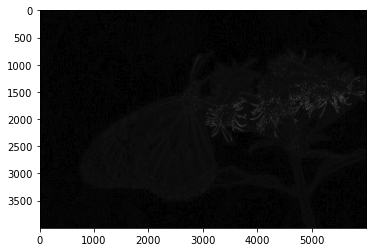

In [12]:
plt.imshow(abs_dest, cmap="gray")

# Perform histogram equalization on the original grayscale image and perform the Otsu thresholding operation

## Histogram equalization 

In [13]:
# convert image into a numpy array
img = convert_to_grayscale(img)
img = np.asarray(img)

(array([1.960000e+03, 1.709800e+04, 5.220600e+04, 9.394700e+04,
        1.093630e+05, 9.573000e+04, 1.574030e+05, 2.433970e+05,
        3.091920e+05, 4.051840e+05, 5.528600e+05, 6.374940e+05,
        1.062698e+06, 1.696063e+06, 2.749023e+06, 2.716843e+06,
        2.431343e+06, 2.190072e+06, 1.891648e+06, 1.326588e+06,
        9.360660e+05, 4.011680e+05, 1.723360e+05, 1.605950e+05,
        1.356710e+05, 1.978860e+05, 2.352780e+05, 2.300000e+05,
        2.432770e+05, 2.405360e+05, 2.131430e+05, 1.826790e+05,
        1.578310e+05, 1.188170e+05, 1.402450e+05, 1.410410e+05,
        1.454770e+05, 1.609580e+05, 1.747330e+05, 1.818850e+05,
        1.745010e+05, 1.292100e+05, 1.431990e+05, 1.171260e+05,
        7.461400e+04, 3.675100e+04, 1.229100e+04, 1.927000e+03,
        4.670000e+02, 1.800000e+02]),
 array([  8.  ,  12.88,  17.76,  22.64,  27.52,  32.4 ,  37.28,  42.16,
         47.04,  51.92,  56.8 ,  61.68,  66.56,  71.44,  76.32,  81.2 ,
         86.08,  90.96,  95.84, 100.72, 105.6 , 11

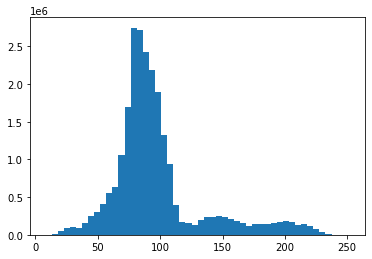

In [14]:
# put pixels in a 1D array by flattening out img array
flat = img.flatten()

# show the histogram
plt.hist(flat, bins=50)

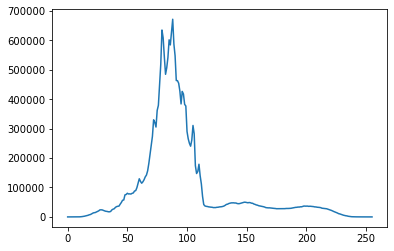

In [15]:
# create our own histogram function
def get_histogram(image, bins):
    # array with size of bins, set to zeros
    histogram = np.zeros(bins)
    
    # loop through pixels and sum up counts of pixels
    for pixel in image:
        histogram[pixel] += 1
    
    # return our final result
    return histogram

hist = get_histogram(flat, 256)

plt.plot(hist)

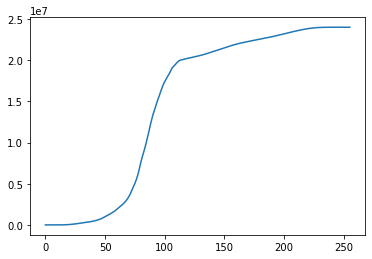

In [16]:
# create our cumulative sum function
def cumsum(a):
    a = iter(a)
    b = [next(a)]
    for i in a:
        b.append(b[-1] + i)
    return np.array(b)

# execute the fn
cs = cumsum(hist)

# display the result
plt.plot(cs)

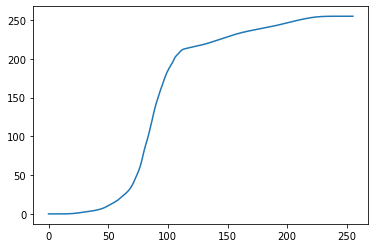

In [17]:
# re-normalize cumsum values to be between 0-255

# numerator & denomenator
nj = (cs - cs.min()) * 255
N = cs.max() - cs.min()

# re-normalize the cdf
cs = nj / N

plt.plot(cs)

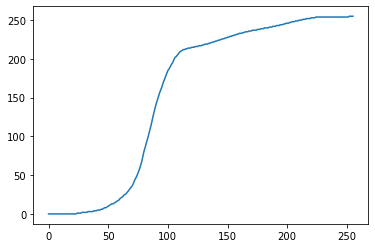

In [18]:
# cast it back to uint8 since we can't use floating point values in images
cs = cs.astype('uint8')

plt.plot(cs)

(array([564460., 437958., 483062., 432193., 480234., 434377., 393107.,
        513141., 329634., 626065., 361580., 378784., 446217., 518130.,
        634495., 607444., 542737.,      0., 484115., 506324., 541369.,
        601191., 583844., 626610.,      0., 671038., 586734., 546961.,
        462871., 462616., 453659., 427392., 383534., 843100., 382094.,
        376513., 555147., 489990., 260959., 766402., 480097., 540390.,
        484013., 463332., 482366., 442468., 472886., 493579., 461977.,
        482811.]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 193.8, 198.9, 204. , 209.1, 214.2, 219.3, 224.4,
        229.5, 234.6, 239.7, 244.8, 249.9, 255. ]),
 <BarContainer object of 50 artists>)

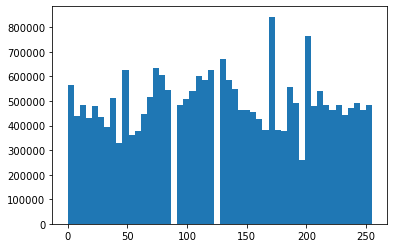

In [19]:
# get the value from cumulative sum for every index in flat, and set that as img_new
img_new = cs[flat]

# we see a much more evenly distributed histogram
plt.hist(img_new, bins=50)

In [20]:
# put array back into original shape since we flattened it
img_new = np.reshape(img_new, img.shape)
img_new

array([[26, 26, 26, ..., 17, 17, 17],
       [26, 26, 26, ..., 17, 17, 17],
       [26, 26, 26, ..., 17, 17, 17],
       ...,
       [ 3,  3,  3, ..., 86, 86, 86],
       [ 3,  3,  3, ..., 86, 86, 86],
       [ 3,  3,  3, ..., 86, 86, 86]], dtype=uint8)

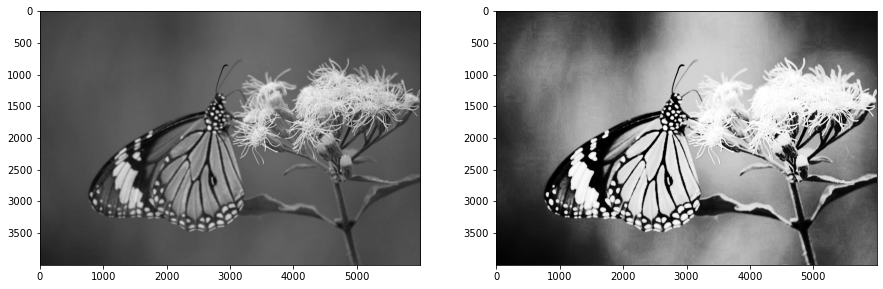

In [21]:
# set up side-by-side image display
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

fig.add_subplot(1,2,1)
plt.imshow(img, cmap='gray')

# display the new image
fig.add_subplot(1,2,2)
plt.imshow(img_new, cmap='gray')

plt.show(block=True)

# Otsu Thresholding


In [9]:
def otsu(image):

    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    total = image.shape[0]*image.shape[1]
    current_max, threshold = 0, 0
    sumT, sumF, sumB = 0, 0, 0
    
    for i in range(0,256):
        sumT += i * hist[i]
    
    weightB, weightF = 0, 0
    
    for i in range(0,256):
        weightB += hist[i]
        weightF = total - weightB
        if weightF == 0: # only background pixels
            break
        
        sumB += i*hist[i]
        sumF = sumT - sumB
        
        meanB = sumB/weightB
        meanF = sumF/weightF 
        
        varBetween = weightB*weightF*(meanB-meanF)**2
        if varBetween > current_max:
            current_max = varBetween
            threshold = i  
    
    th = image
    th[th>=threshold]=255
    th[th<threshold]=0
    
    return th

In [23]:
img = cv2.imread('./images/Butterfly.JPG')
img = convert_to_grayscale(img)
blur = scaling(img, 3, 5)
sharpened = sharpen(blur)

In [24]:
otsu_thresh = otsu(sharpened)


Save(0) or Show(1) image? 1


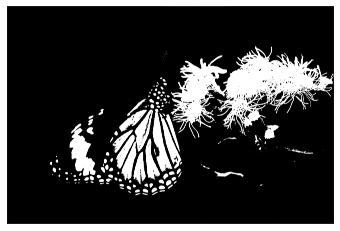

In [27]:
show_image('otsu.png', otsu_thresh, cmap='gray')

## Perform Harris corner detection on the gray image and display the detected corners

In [6]:
def edge_sobel(image):
    Sx = np.array([
        [-1,0,1],
        [-2,0,2],
        [-1,0,1]
    ])
    Sx = Sx / 8.0
    
    Sy = np.array([
        [-1,-2,-1],
        [0,0,0],
        [1,2,1]
    ])
    Sy = Sy / 8.0
    
    Ix = filter2D(image, Sx)
    Iy = filter2D(image, Sy)
    
    grads = np.sqrt(Ix**2 + Iy**2)
    return Ix, Iy, grads

In [7]:
def harris(img, threshold=1e-2, nms_size=10):
    
    img_gray = convert_to_grayscale(img)
    blur = scaling(img_gray, 3, 5)
    otsu_thresh = otsu(blur)
    
    Ix, Iy, _ = edge_sobel(otsu_thresh)
    Ixx = scaling(Ix*Ix, 3, 5)
    Ixy = scaling(Ix*Iy, 3, 5)
    Iyy = scaling(Iy*Iy, 3, 5)
    
    detA = Ixx*Iyy - Ixy**2
    traceA = Ixx + Iyy
    Rs = detA - 0.05*traceA**2
    
    img_copy_for_corners = np.copy(img)    
    
    # thresholding
    Rs = Rs * (Rs > (threshold * Rs.max())) * (Rs > 0)
    
    # Non maxima suppression
    rows, columns = np.nonzero(Rs)
    new_Rs = np.zeros(Rs.shape)
    for r,c in zip(rows,columns):
        minr = max(0, r - nms_size / 2)
        maxr = min(img.shape[0], minr + nms_size)
        minc = max(0, c - nms_size / 2)
        maxc = min(img.shape[1], minc + nms_size)
        if Rs[r,c] == Rs[int(minr):int(maxr),int(minc):int(maxc)].max():
            new_Rs[r,c] = Rs[r,c]
   
    # Corners found
    corners_x,corners_y = np.nonzero(new_Rs)

    for x,y in zip(corners_x, corners_y):
        img_copy_for_corners=cv2.circle(img_copy_for_corners, (y,x), 2, (255,0,0), -1)
        
    return img_copy_for_corners

In [10]:
imgcv = cv2.imread('./images/Butterfly.JPG')
harris_img = harris(imgcv, 1e-2, 10)


C:\Users\hp\AppData\Local\Temp/ipykernel_6892/4274536089.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  meanB = sumB/weightB



Save(0) or Show(1) image? 1


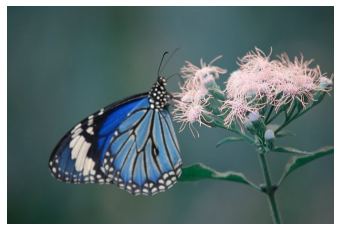

In [11]:
show_image('harris.png', harris_img, cmap=None)